In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from PIL import Image
import imageio
import pickle
import pandas as pd
import os
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [24]:
record_timestamp = "20241006_233033"

record_timestamp

'20241006_233033'

In [11]:
with open("features.pkl", "rb") as f:
    df_features = pickle.load(f)
nd_features = df_features.values

nd_features.shape

(218, 6)

In [12]:
with open(
    f"output/{record_timestamp}/{record_timestamp}_analysis_population.pkl",
    "rb",
) as f:
    df_iterations = pickle.load(f)

In [13]:
all_pops_cat = []
for pop in df_iterations["pop"].unique():
    df_gen = df_iterations.loc[
        df_iterations["pop"] == pop, ["p1", "p2", "p3", "p4", "p5", "p6"]
    ]
    i_bar = df_gen.mean(axis=0)
    var = np.sum((df_gen - i_bar) ** 2, axis=0) / len(df_gen.index)
    all_pops_cat.append(np.mean(var))

np.array(all_pops_cat).shape

(150,)

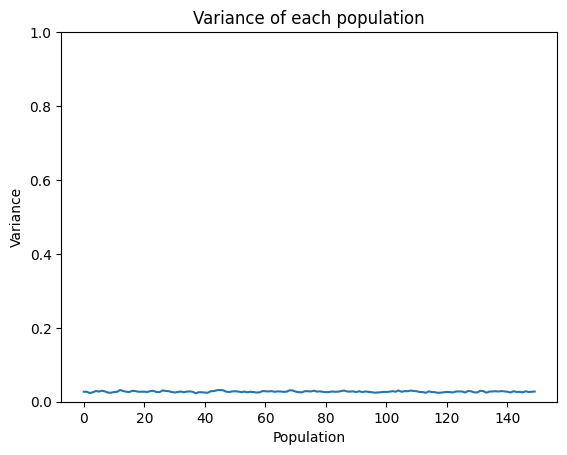

In [14]:
# plot variance
plt.plot(all_pops_cat)
plt.xlabel("Population")
plt.ylabel("Variance")
plt.title("Variance of each population")
plt.ylim(0, 1)
plt.show()

In [15]:
# plot categorical variance

with open("filenames.pkl", "rb") as f:
    df_filenames = pickle.load(f)
df_filenames.filename = df_filenames.filename.apply(os.path.splitext).str[0]

df_filenames.head()

,filename,sample_id
0,349217,0
1,399910,1
2,355149,2
3,35437,3
4,235105,4


In [16]:
# Load the metadata file

df_metacoll = pd.read_csv(
    r"D:\datasets\FSD50K\FSD50K.metadata\collection\collection_dev.csv"
)
df_metacoll.mids = df_metacoll.mids.str.split(",")
df_metacoll.fname = df_metacoll.fname.astype(str)

df_metacoll.head()

,fname,labels,mids
0,64760,Electric_guitar,[/m/02sgy]
1,16399,Electric_guitar,[/m/02sgy]
2,16401,Electric_guitar,[/m/02sgy]
3,16402,Electric_guitar,[/m/02sgy]
4,16404,Electric_guitar,[/m/02sgy]


In [17]:
df_iter_w_filename = df_iterations.merge(
    df_filenames, on="sample_id", how="left"
)
df_iter_w_filename.filename = df_iter_w_filename.filename.astype(str)

df_iter_w_filename.head()

,p1,p2,p3,p4,p5,p6,score,pop,sample_id,id,iteration,path_id,projection_method,corpus_method,filename
0,0.256766,0.436668,0.124341,0.427692,0.108590,0.048734,-1,2,153,200,0,0,tsne,read,374237
1,0.289581,0.439002,0.087508,0.415841,0.341846,0.000726,-1,2,132,201,0,0,tsne,read,204648
2,0.073548,0.873121,0.531131,0.544816,0.782904,0.140546,-1,2,57,202,0,0,tsne,read,433669
3,0.002685,0.801494,0.431975,0.204664,0.301127,0.028617,-1,2,55,203,0,0,tsne,read,269117
4,0.482050,0.779908,0.246573,1.000000,0.473651,0.171023,-1,2,35,204,0,0,tsne,read,340553


In [18]:
df_ontology_lookup = df_iter_w_filename.merge(
    df_metacoll, left_on="filename", right_on="fname", how="left"
)
df_ontology_lookup["mids_first"] = df_ontology_lookup.mids.str[0]

df_ontology_lookup.head()

,p1,p2,p3,p4,p5,p6,score,pop,sample_id,id,iteration,path_id,projection_method,corpus_method,filename,fname,labels,mids,mids_first
0,0.256766,0.436668,0.124341,0.427692,0.108590,0.048734,-1,2,153,200,0,0,tsne,read,374237,374237,Brass_instrument,[/m/01kcd],/m/01kcd
1,0.289581,0.439002,0.087508,0.415841,0.341846,0.000726,-1,2,132,201,0,0,tsne,read,204648,204648,Marimba_and_xylophone,[/m/0dwsp],/m/0dwsp
2,0.073548,0.873121,0.531131,0.544816,0.782904,0.140546,-1,2,57,202,0,0,tsne,read,433669,433669,Keys_jangling,[/m/03v3yw],/m/03v3yw
3,0.002685,0.801494,0.431975,0.204664,0.301127,0.028617,-1,2,55,203,0,0,tsne,read,269117,269117,"Hands,Crack","[/m/0k65p, /m/07qs1cx]",/m/0k65p
4,0.482050,0.779908,0.246573,1.000000,0.473651,0.171023,-1,2,35,204,0,0,tsne,read,340553,340553,Tools,[/m/07k1x],/m/07k1x


In [19]:
# categorical diversity

all_pops_cat = []
for pop in df_ontology_lookup["pop"].unique():
    cats = df_ontology_lookup.loc[
        df_ontology_lookup["pop"] == pop, "mids_first"
    ]
    all_pops_cat.append(len(set(cats)) / len(cats))

np.array(all_pops_cat).shape

(150,)

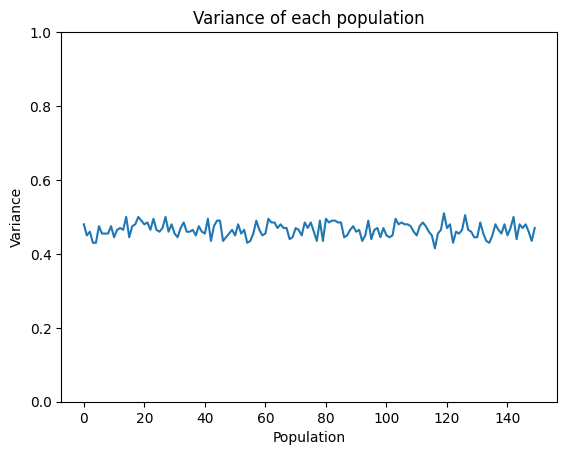

In [20]:
# plot variance
plt.plot(all_pops_cat)
plt.xlabel("Population")
plt.ylabel("Variance")
plt.title("Variance of each population")
plt.ylim(0, 1)
plt.show()

In [50]:
# pairwise distances

# load the graph to nx
import networkx as nx

with open(
    f"output/{record_timestamp}/{record_timestamp}_analysis_evo_graph.gpickle",
    "rb",
) as f:
    G = pickle.load(f)

G.number_of_nodes()

30088

In [57]:
# get the leaf nodes based on pop label in nodes
leaf_nodes = [n for n in G.nodes(data=True) if n[1]["pop"] == 151]

len(leaf_nodes)

88

In [ ]:
######## comment out

for iteration in df_iterations.iteration.unique()[:1]:
    df_epoch = df_iterations[df_iterations.iteration == iteration]
    df_epoch = df_epoch[["p1", "p2", "p3", "p4", "p5", "p6"]]

df_epoch

In [53]:
# Scale the features
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(nd_features)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(nd_features)
labels = kmeans.labels_

# Save the DataFrame with cluster labels
df_features["cluster"] = labels
with open("features_clustered_TEST.pkl", "wb") as f:
    pickle.dump(df_features, f)
###

# print(df_features.head())
# print(df_features.describe())
print(df_features.cluster.value_counts())

cluster
3    56
4    53
2    43
0    36
1    30
Name: count, dtype: int64


In [ ]:
#### comment out

# find visited indexes
visited_indexes = []
for individual in df_epoch.values:
    for index, feature in enumerate(nd_features):
        if np.array_equal(individual, feature):
            visited_indexes.append(index)
            break
visited_indexes = np.array(visited_indexes)

visited_indexes

In [9]:
# VISUALIZE THE CLUSTERS (2D) with t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_data_tsne = tsne.fit_transform(nd_features)
df_tsne = pd.DataFrame(features_data_tsne, columns=["x", "y"])

output_dir = f"output/{record_timestamp}/clusters"
os.makedirs(output_dir, exist_ok=True)

figure_filenames = []
for i, iteration in enumerate(df_iterations.iteration.unique()[:10]):
    df_epoch = df_iterations[df_iterations.iteration == iteration]
    df_epoch = df_epoch[["p1", "p2", "p3", "p4", "p5", "p6"]]

    # find visited indexes
    visited_indexes = []
    for individual in df_epoch.values:
        for index, feature in enumerate(nd_features):
            if np.array_equal(individual, feature):
                visited_indexes.append(index)
                break
    visited_indexes = np.array(visited_indexes)

    df_tsne["cluster"] = labels

    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.scatter(
        df_tsne["x"], df_tsne["y"], s=1, c=df_tsne["cluster"], cmap="viridis"
    )
    plt.scatter(
        df_tsne["x"].iloc[visited_indexes],
        df_tsne["y"].iloc[visited_indexes],
        c="red",
        s=3,
        marker="^",
    )
    # plt.show()

    output_file = os.path.join(output_dir, f"generation_{i}.png")
    plt.savefig(output_file)
    figure_filenames.append(output_file)

"end"

In [8]:
# make a gif

# Load each figure and append it to the images list
images = []
for filename in figure_filenames:
    image = Image.open(filename)
    images.append(image)

# Save the images as a GIF
output_filename = os.path.join(output_dir, "evolution_anim.gif")
imageio.mimsave(output_filename, images, duration=0.1)

# Remove the individual figure files
# for filename in figure_filenames:
#     os.remove(filename)

In [13]:
# VISUALIZE THE CLUSTERS (3D) with t-SNE
tsne = TSNE(n_components=3, random_state=0)
features_data_tsne = tsne.fit_transform(nd_features)

df_tsne = pd.DataFrame(features_data_tsne, columns=["x", "y", "z"])
df_tsne["cluster"] = labels

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    df_tsne["x"],
    df_tsne["y"],
    df_tsne["z"],
    c=df_tsne["cluster"],
    cmap="viridis",
)
plt.show()
plt.savefig("clusters_3d_TEST.png")